# A Simple Neural Network

We'll continue from where we left off in the previous notebook where we implemented the `Value` object, which is used to perform backpropagation in a computational graph. In this notebook, we'll implement a simple neural network using the `Value` object.

In [1]:
# To allow importing modules from the nnfs directory, can be ignored
import sys
import os

# Get the absolute path of the 'src' directory
src_dir = os.path.abspath(os.path.join(os.getcwd(), os.pardir))

# Add 'src' directory to the Python path
if src_dir not in sys.path:
    sys.path.append(src_dir)

In [2]:
import math
import random

import numpy as np
import matplotlib.pyplot as plt
# Must first download graphviz: https://graphviz.org/download/

from nnfs.trace_graph import draw_dot  
from nnfs.autograd import Value

%matplotlib inline

## The Neuron

An artificial neuron is a fundamental building block of dense neural networks. It's inspired by biological neurons in the human brain, but is a simplified, mathematical model.

![An artificial neuron](../neuron_model.png)

Here's a basic breakdown:

1. **Inputs**: The artificial neuron receives one or more inputs. These could be raw data points, like pixels from an image.
2. **Weights**: Each input has an associated weight, which can be adjusted over time. Think of these weights as dials or knobs that can be turned to make the neuron behave differently.
3. **Summation**: The neuron multiplies each input by its weight, then sums up all these products.
4. **Activation Function**: This sum then passes through an activation function. The purpose of this function is to introduce non-linearity to the model, which allows neural networks to learn complex patterns. Common activation functions include the sigmoid, ReLU, and tanh.
4. **Output**: The result from the activation function is the output of the neuron, which can then serve as an input to another neuron in the next layer of a neural network.

In essence, the artificial neuron takes in data, processes it using its weights and the activation function, and then outputs a result.

#### Activation Function

In this notebook, we'll use the $\tanh$ as activation function, which is defined as:

$$\tanh(x) = \frac{e^{2x} - 1}{e^{2x} + 1}$$

$\tanh$, is a mathematical function that squishes the input values to values in the range (-1, 1) as a s-curve.
It is used because it a smooth, differential, and non-linear function with values centered around zero, which are 
all properties that are useful for neural networks.

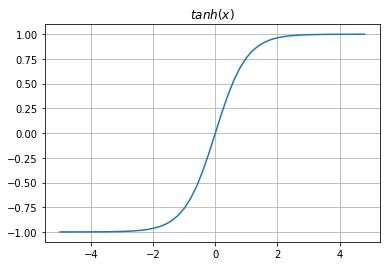

In [3]:
plt.plot(np.arange(-5,5,0.2), np.tanh(np.arange(-5,5,0.2)))
plt.grid()
plt.title('$tanh(x)$')
plt.show()

We'll now implement a neuron with two inputs using the `Value` object. We'll later convert this to a class so we can generalize it to neurons with any number of inputs and outputs.

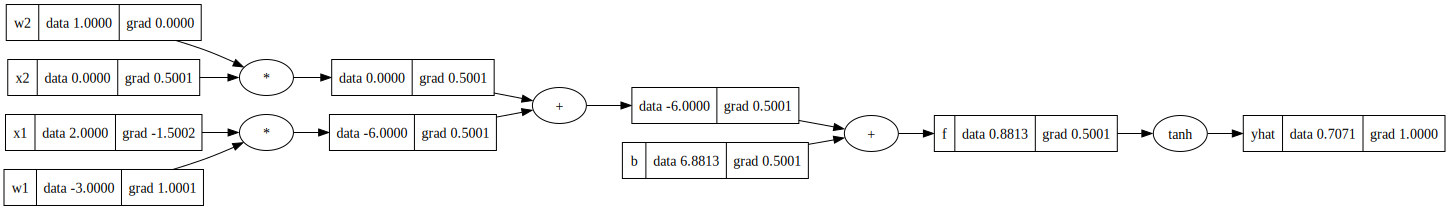

In [10]:
# inputs
x = [Value(2.0, label='x1'), Value(0.0, label='x2')]
# weights and bias
w = [Value(-3.0, label='w1'), Value(1.0, label='w2')]
b = Value(6.8813, label='b')

f = x[0] * w[0] + x[1] * w[1] + b; f.label = 'f'
yhat = f.tanh(); yhat.label = 'yhat'
yhat.backward()
draw_dot(yhat)

We usually initialize the weights randomly. If all weights are initialized with the same value, every neuron in the hidden layer will produce the same output and undergo the same weight updates during training. This makes the neurons in that layer symmetric and redundant. Random initialization ensures that each neuron starts with a different weight and thus follows a unique gradient during training.

In [5]:
class Neuron:
  
    def __init__(self, num_inputs, activation='tanh'):
        self.w = [Value(random.uniform(-1,1)) for _ in range(num_inputs)]
        self.b = Value(random.uniform(-1,1))
        self.activation = activation
  
    def __call__(self, x):
        # w * x + b
        act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
        if self.activation == 'tanh':
            out = act.tanh()
        elif self.activation == 'relu':
            out = act.relu()
        else:  # linear
            out = act
        return out
  
    def parameters(self):
        return self.w + [self.b]
    
    def __repr__(self):
        return f'Neuron({len(self.w)}, {self.b})'

## Neural Network

A neural network is an interconnected collection of many artificial neurons, organized into layers.

![A neural network](../neural_network.jpg)

- **Input Layer**: This is the first layer of the network and receives raw input data. The number of items in this layer is the number of input features.
- **Hidden Layers**: After the input layer, there are one or more "hidden" layers. These layers process and transform the information from the previous layer using artificial neurons. Every neuron in one layer is connected to every neuron in the next layer. 
- **Output Layer**: This is the final layer, which produces the result. For a classification task, for example, the output layer might have a neuron for each possible category, and the neuron with the highest value might represent the network's chosen category.

What we update is the weights of connections between neurons. The weights are the values that backpropagation adjusts to make the network learn.